In [4]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.calc import moist_lapse
from metpy.units import units
import climlab

p = np.linspace(1000, 100, 20) * units.hPa
T_sfc = 303 * units.K
T_atm = moist_lapse(p, 300 * units.K)


state = climlab.column_state(lev=p.magnitude, water_depth=1.0)

state['Tatm'][:] = T_atm.magnitude.copy()[::-1]
state['Ts'][:]   = T_sfc.magnitude

p_lev  = state.Tatm.domain.lev.points
T_lev  = state['Tatm'].base
# RH = 80%
qvs_lev = climlab.utils.thermo.qsat(T_lev, p_lev)
qv_lev = qvs_lev * 0.8

nlev = len(p_lev)
# print(p_lev)
# print(T_lev) 
# print(qv_lev) # <class 'numpy.ndarray'>
print(state)

AttrDict({'Ts': Field([303.]), 'Tatm': Field([190.50136004, 212.64823517, 229.46079052, 242.24488888,
       251.90863876, 259.35912838, 265.30087313, 270.20047675,
       274.35554613, 277.95898973, 281.14002357, 283.98834603,
       286.56829619, 288.92739476, 291.10164892, 293.11895174,
       295.00132026, 296.76643138, 298.42869724, 300.        ])})


Text(0.5, 1.0, 'R_SW from qv [K/day per -20%RH]')

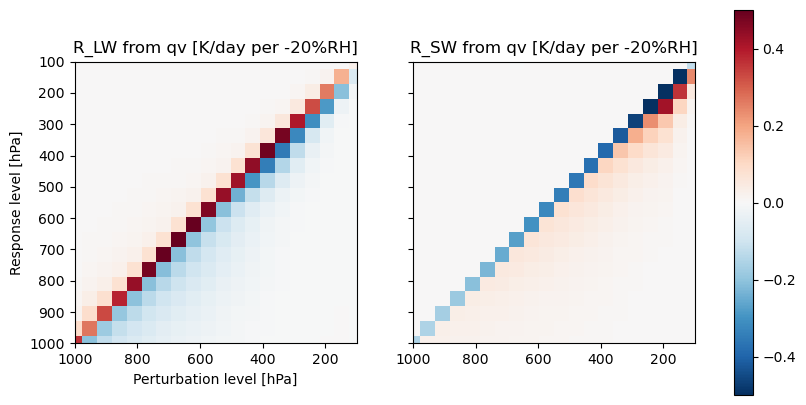

In [38]:
rad_base = climlab.radiation.RRTMG(name='Rad_base',
                                   state=state,
                                   specific_humidity=qvs_lev,
                                   albedo=0.3)

rad_base.compute_diagnostics()
LW_ref = rad_base.diagnostics['TdotLW'].copy()
SW_ref = rad_base.diagnostics['TdotSW'].copy()

kernel_LW = np.zeros((nlev, nlev))
kernel_SW = np.zeros((nlev, nlev))

for k in range(nlev):
    # qv perturbation at k lev, RH80 to RH100
    qv_pert = qvs_lev.copy()
    delta_qv = qvs_lev[k] - qv_lev[k]
    qv_pert[k] -= delta_qv

    # Fresh radiation model per perturbation
    rad_pert = climlab.radiation.RRTMG(name=f'Rad_pert_{k}',
                                       state=state,
                                       specific_humidity=qv_pert,
                                       albedo=0.3)
    rad_pert.compute_diagnostics()
    LW_pert = rad_pert.diagnostics['TdotLW'].copy()
    SW_pert = rad_pert.diagnostics['TdotSW'].copy()

    # Compute kernel column (response at all levels to impulse at level k)
    kernel_LW[:, k] = (LW_pert - LW_ref)
    kernel_SW[:, k] = (SW_pert - SW_ref)
    
# === Step 7: Plot total radiative response kernel ===
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
cs1 = axs[0].pcolormesh(p_lev, p_lev, (kernel_LW), cmap='RdBu_r',
                        vmin=-0.5, vmax=0.5)
cs2 = axs[1].pcolormesh(p_lev, p_lev, (kernel_SW), cmap='RdBu_r',
                        vmin=-0.5, vmax=0.5)
cbar = fig.colorbar(cs1, ax=axs)

for ax in axs:
    ax.set_aspect('equal')
del ax
#plt.contour(p_levels, p_levels, (kernel_LW + kernel_SW)*1e-3, levels=[0,0.001],color='k')
axs[0].set_xlim([1000, 100])
axs[0].set_ylim([1000, 100])
axs[0].set_xlabel('Perturbation level [hPa]')
axs[0].set_ylabel('Response level [hPa]')
axs[0].set_title('R_LW from qv [K/day per -20%RH]')
axs[1].set_title('R_SW from qv [K/day per -20%RH]')